In [ ]:
import json
file_path=r"C:\Users\user\Desktop\Zeru\data\user-wallet-transactions.json"
with open(file_path,'r') as f:
    data=json.load(f)

In [ ]:
import pandas as pd

# Sample: assume `data` is your JSON list
flattened_data = []

for tx in data:
    try:
        tx_flat = {
            "_id": tx.get('_id', {}).get('$oid'),
            "userWallet": tx.get('userWallet'),
            "network": tx.get('network'),
            "protocol": tx.get('protocol'),
            "txHash": tx.get('txHash'),
            "logId": tx.get('logId'),
            "timestamp": tx.get('timestamp'),
            "blockNumber": tx.get('blockNumber'),
            "action": tx.get('action'),
            "action_type": tx.get('actionData', {}).get('type'),
            "amount_raw": tx.get('actionData', {}).get('amount'),
            "assetSymbol": tx.get('actionData', {}).get('assetSymbol'),
            "assetPriceUSD": tx.get('actionData', {}).get('assetPriceUSD'),
            "poolId": tx.get('actionData', {}).get('poolId'),
            "userId": tx.get('actionData', {}).get('userId'),
            "__v": tx.get('__v'),
            "createdAt": tx.get('createdAt', {}).get('$date'),
            "updatedAt": tx.get('updatedAt', {}).get('$date')
        }

        # Convert amount and price
        try:
            amount = float(tx_flat["amount_raw"])
        except:
            amount = None
        try:
            price = float(tx_flat["assetPriceUSD"])
        except:
            price = None

        tx_flat["amount"] = amount
        tx_flat["usd_value"] = amount * price if amount and price else None

        flattened_data.append(tx_flat)

    except Exception as e:
        print(f"Error parsing record: {e}")

# Convert to DataFrame
df = pd.DataFrame(flattened_data)




In [ ]:
df['protocol'].value_counts()

protocol
aave_v2    100000
Name: count, dtype: int64

In [ ]:
df['network'].value_counts()

network
polygon    100000
Name: count, dtype: int64

In [ ]:
df['blockNumber'] # same as  timestamp

0        1629178166
1        1621525013
2        1627118913
3        1627773318
4        1618845907
            ...    
99995    1623421245
99996    1623558779
99997    1623559191
99998    1623559417
99999    1623745577
Name: blockNumber, Length: 100000, dtype: int64

In [ ]:
# Step 1: Calculate mode (most frequent asset symbol)
most_common_asset = df.loc[df['assetSymbol'] != '', 'assetSymbol'].mode().iloc[0]

# Step 2: Replace '' with mode
df['assetSymbol'] = df['assetSymbol'].replace('', most_common_asset)

In [ ]:
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['assetPriceUSD'] = pd.to_numeric(df['assetPriceUSD'], errors='coerce')

# Calculate USD value
df['usd_value'] = df['amount'] * df['assetPriceUSD']
df.drop(['amount', 'assetPriceUSD'], axis=1, inplace=True)


In [ ]:
columns_to_drop = [
    '_id',  # internally MongoDB generated ID
    'network',  # always having the same value
    'protocol',  # always having the same value
    'txHash',  # not useful
    'logId',  # not useful for analysis
    'blockNumber',  # same as timestamp
    'action_type',  # same as action
    'amount_raw',  # already processed as amount
    'poolId',  # pool contract address
    'userId',  # already made userWallet
    '__v',  # MongoDB version ID
    'createdAt',  # internal metadata
    'updatedAt' # internal metadata

]


In [ ]:
df['usd_value'].isnull().sum()

0

In [ ]:
dataset=df.drop(columns_to_drop,axis=1)

In [ ]:
most_used_asset = dataset.groupby("userWallet")["assetSymbol"].agg(lambda x: x.mode())


In [ ]:
asset_usage = dataset.groupby("assetSymbol")["usd_value"].sum().sort_values(ascending=False)


In [ ]:
num_unique_assets = dataset.groupby("userWallet")["assetSymbol"].nunique()


In [ ]:
top_deposits = dataset[dataset['action'] == 'deposit'].groupby('assetSymbol')['usd_value'].sum().sort_values(ascending=False)
top_borrows = dataset[dataset['action'] == 'borrow'].groupby('assetSymbol')['usd_value'].sum().sort_values(ascending=False)


In [ ]:
top_borrows

assetSymbol
DAI       1.075603e+26
WETH      7.515207e+25
WMATIC    3.498040e+25
WPOL      3.097712e+25
WBTC      6.617478e+14
USDC      9.653726e+13
USDT      5.932891e+13
Name: usd_value, dtype: float64

In [ ]:
dataset=pd.merge(dataset,most_used_asset.reset_index(),how='left',on='userWallet')

In [ ]:
dataset['assetSymbol']=dataset['assetSymbol_y']

In [ ]:
dataset.drop("assetSymbol_y",axis=1,inplace=True)

In [ ]:
dataset = pd.merge(
    dataset,
    num_unique_assets.reset_index(),
    on="userWallet",
    how='left',
    suffixes=('', '_drop')  # avoids duplicate column error
)


In [ ]:
dataset.rename(columns={
    'assetSymbol': 'Most_Assest_Used ',
    'assetSymbol_drop': 'Unique_Assest_Used'
}, inplace=True)


In [ ]:
dataset.drop("assetSymbol_x",axis=1,inplace=True)

In [ ]:
dataset

,userWallet,timestamp,action,usd_value,Most_Assest_Used,Unique_Assest_Used
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1629178166,deposit,1.987664e+09,USDC,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1621525013,deposit,2.856945e+20,WMATIC,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,1627118913,deposit,9.223773e+14,WMATIC,1
3,0x000000000096026fb41fc39f9875d164bd82e2dc,1627773318,deposit,4.229933e+15,WMATIC,1
4,0x0000000000e189dd664b9ab08a33c4839953852c,1618845907,redeemunderlying,5.026161e+05,WETH,4
...,...,...,...,...,...,...
99995,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,1623421245,repay,1.976766e+10,USDT,7
99996,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,1623558779,redeemunderlying,4.684078e+21,USDT,7
99997,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,1623559191,deposit,4.670059e+21,USDT,7
99998,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,1623559417,borrow,4.007604e+09,USDT,7


In [ ]:
import numpy as np 

# Step 2: Group by userWallet and create features
group = dataset.groupby("userWallet")

wallet_features = group.agg(
    total_transactions=('action', 'count'),
    num_deposits=('action', lambda x: (x == 'deposit').sum()),
    num_borrows=('action', lambda x: (x == 'borrow').sum()),
    num_repays=('action', lambda x: (x == 'repay').sum()),
    num_liquidations=('action', lambda x: (x == 'liquidationcall').sum()),
    num_redeems=('action', lambda x: (x == 'redeemunderlying').sum()),
    
    total_deposit_usd=('usd_value', lambda x: x[dataset.loc[x.index, 'action'] == 'deposit'].sum()),
    total_borrow_usd=('usd_value', lambda x: x[dataset.loc[x.index, 'action'] == 'borrow'].sum()),
    total_repay_usd=('usd_value', lambda x: x[dataset.loc[x.index, 'action'] == 'repay'].sum()),
    total_redeem_usd=('usd_value', lambda x: x[dataset.loc[x.index, 'action'] == 'redeemunderlying'].sum()),
    
    avg_tx_usd=('usd_value', 'mean'),
    std_tx_usd=('usd_value', 'std'),
    
    
    first_tx_timestamp=('timestamp', 'min'),
    last_tx_timestamp=('timestamp', 'max'),
    active_days=('timestamp', lambda x: pd.to_datetime(x, unit='s').dt.date.nunique())
)

# Step 3: Derived ratio & risk features
wallet_features["borrow_to_repay_ratio"] = wallet_features["total_borrow_usd"] / wallet_features["total_repay_usd"].replace(0, np.nan)
wallet_features["repaid_percentage"] = wallet_features["total_repay_usd"] / wallet_features["total_borrow_usd"].replace(0, np.nan)
wallet_features["liquidation_ratio"] = wallet_features["num_liquidations"] / wallet_features["num_borrows"].replace(0, np.nan)
wallet_features["deposit_to_borrow_ratio"] = wallet_features["total_deposit_usd"] / wallet_features["total_borrow_usd"].replace(0, np.nan)
wallet_features["redeem_to_deposit_ratio"] = wallet_features["total_redeem_usd"] / wallet_features["total_deposit_usd"].replace(0, np.nan)
wallet_features["net_borrowed"] = wallet_features["total_borrow_usd"] - wallet_features["total_repay_usd"]

# Step 4: Time since last transaction
wallet_features["days_since_last_tx"] = (pd.Timestamp.now().timestamp() - wallet_features["last_tx_timestamp"]) / (3600 * 24)

# Step 5: Final clean-up
wallet_features.fillna(0, inplace=True)
wallet_features.reset_index(inplace=True)


In [ ]:
dataset.columns

Index(['userWallet', 'timestamp', 'action', 'usd_value', 'Most_Assest_Used ',
       'Unique_Assest_Used'],
      dtype='object')

In [ ]:
wallet_features = pd.merge(wallet_features, num_unique_assets.reset_index(), on="userWallet", how="left")
wallet_features = pd.merge(wallet_features, most_used_asset.reset_index(), on="userWallet", how="left")


In [ ]:
wallet_features['credit_score'] = (
    (wallet_features['repaid_percentage'].clip(0, 1.2) * 400) +
    ((1 - wallet_features['liquidation_ratio'].clip(0, 1)) * 200) +
    (wallet_features['redeem_to_deposit_ratio'].clip(0, 1.5) * 150) +
    (wallet_features['active_days'] / wallet_features['active_days'].max() * 100) +
    ((1 / (1 + wallet_features['days_since_last_tx'])) * 150)
).clip(0, 1000)


In [ ]:
wallet_features['credit_score'].min()

1.884373252530551

In [ ]:
wallet_features['assetSymbol_x']=pd.to_numeric(wallet_features['assetSymbol_x'])


In [ ]:
# Step 1: Ensure values are strings, even if they're arrays
wallet_features['assetSymbol_y'] = wallet_features['assetSymbol_y'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)

# Step 2: Fill missing values if any
wallet_features['assetSymbol_y'] = wallet_features['assetSymbol_y'].fillna('unknown')

# Step 3: Encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
wallet_features['assetSymbol_y'] = le.fit_transform(wallet_features['assetSymbol_y'])


In [ ]:
wallet_features['assetSymbol_y'].value_counts()

assetSymbol_y
2     955
3     554
6     423
7     399
1     300
     ... 
38      1
28      1
42      1
12      1
32      1
Name: count, Length: 62, dtype: int64

In [ ]:
X=wallet_features.drop(["userWallet","credit_score"],axis=1)
y=wallet_features['credit_score']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor


model=RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
from xgboost import XGBRegressor
m=XGBRegressor(early_stopping=10)
m.fit(X_train,y_train)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping=10,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
m.score(X_test,y_test)

0.9972744527516867

NameError: name 'mean_squared_error' is not defined

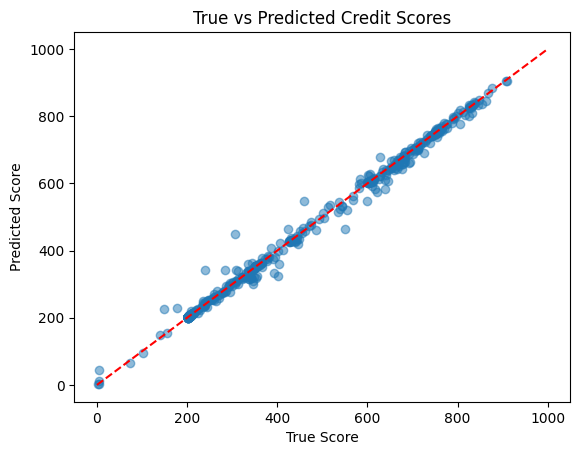

In [ ]:
import matplotlib.pyplot as plt

y_pred =m.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("True vs Predicted Credit Scores")
plt.plot([0, 1000], [0, 1000], 'r--')  # Ideal line
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(m, X, y, cv=5, scoring=mse_scorer)
print("Cross-validated MSE:", scores)


Cross-validated MSE: [ 74.25359072 102.32699753 244.24402148  87.63960414  53.77830177]


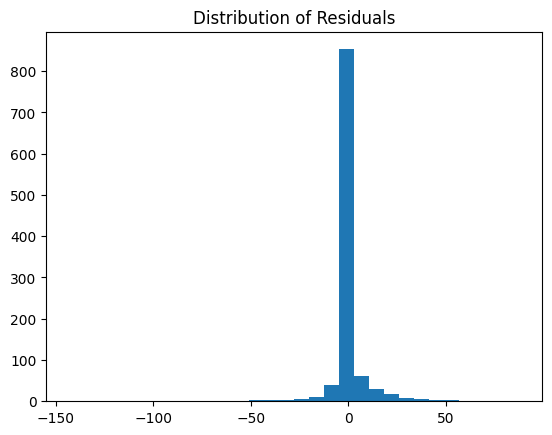

In [ ]:
import matplotlib.pyplot as plt
y_pred=m.predict(X_test)
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title("Distribution of Residuals")
plt.show()


In [ ]:
wallet_features['predicted_score'] = m.predict(X)
wallet_features[['userWallet', 'predicted_score']].to_csv("wallet_score_output.csv", index=False)
print("✅ Final credit scores saved to 'wallet_score_output.csv'")


In [ ]:
model.score(X_train,y_train)

0.9995676269274877

In [ ]:
model.score(X_test,y_test)

0.9966823002835627

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [ ]:
mean_squared_error(y_test,model.predict(X_test))

148.91106667001037

<Axes: xlabel='credit_score', ylabel='Count'>

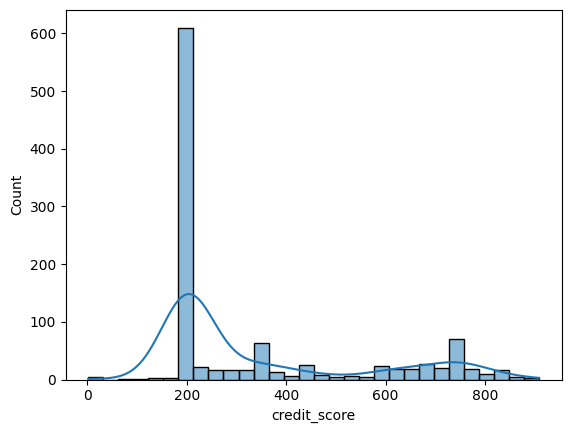

In [ ]:
import seaborn as sns
sns.histplot(y_test, bins=30, kde=True)


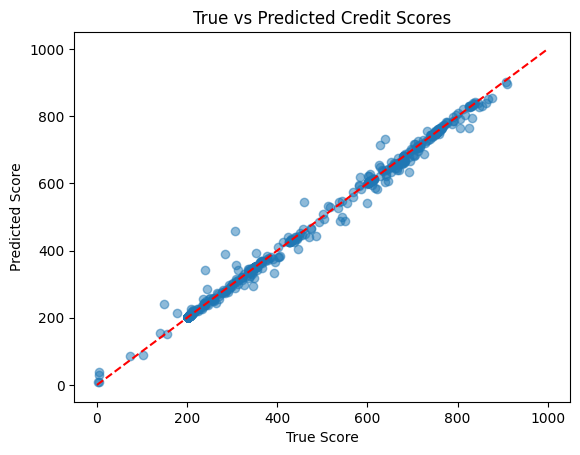

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("True vs Predicted Credit Scores")
plt.plot([0, 1000], [0, 1000], 'r--')  # Ideal line
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

mse_scorer = make_scorer(mean_squared_error)
scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
print("Cross-validated MSE:", scores)


Cross-validated MSE: [157.27605534 163.1866158  386.99114468  85.81816599  91.05901273]


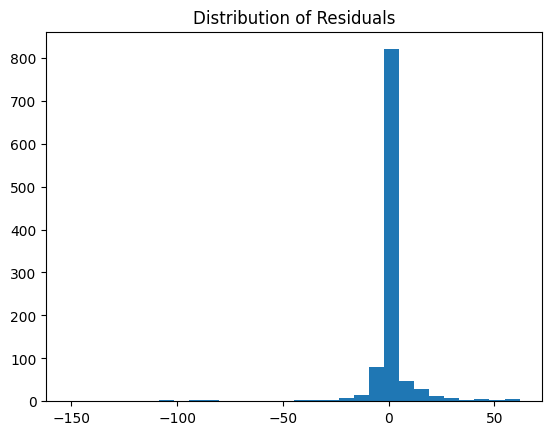

In [ ]:
import matplotlib.pyplot as plt
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title("Distribution of Residuals")
plt.show()


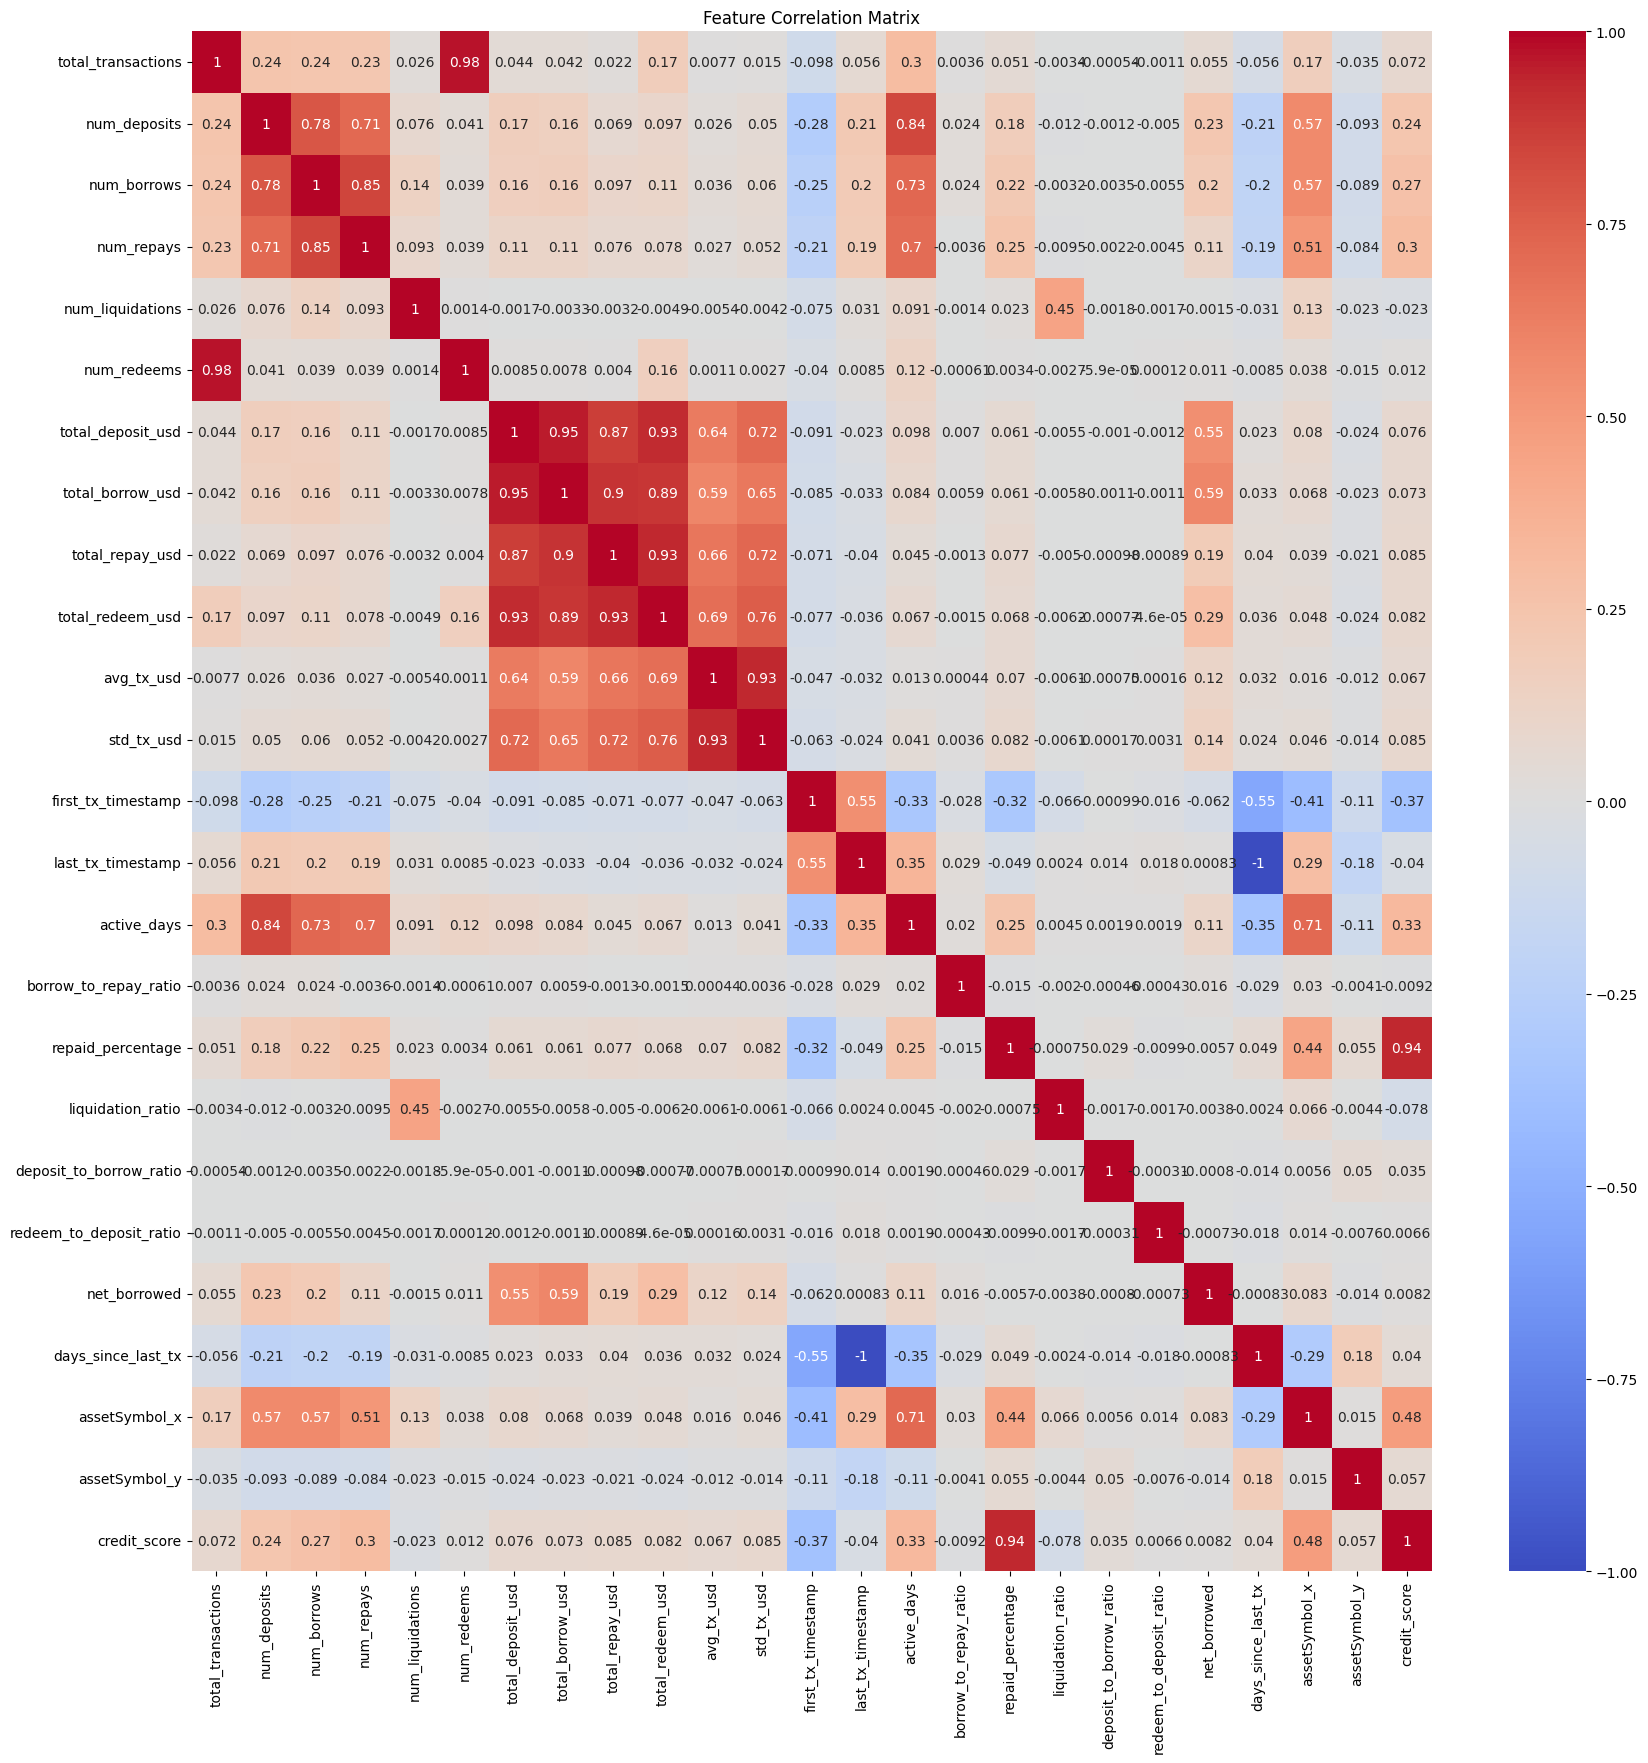

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = wallet_features.drop("userWallet",axis=1).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
columns=[
    # ➊ Positively correlated
    'repaid_percentage',   # ρ ≈ +0.94
    'assetSymbol_x',       # ρ ≈ +0.48
    'active_days',         # ρ ≈ +0.33
    'num_repays',          # ρ ≈ +0.30

    # ➋ Negatively correlated
    'first_tx_timestamp'   # ρ ≈ –0.37
]


,repaid_percentage,assetSymbol_x,active_days,num_repays,first_tx_timestamp
0,0.000000e+00,1,1,0,1629178166
1,0.000000e+00,1,1,0,1621525013
2,0.000000e+00,1,2,0,1627118913
3,0.000000e+00,4,8,0,1618845797
4,1.163400e-12,6,104,4,1619040510
...,...,...,...,...,...
3492,0.000000e+00,1,1,0,1626129103
3493,0.000000e+00,3,1,0,1622359339
3494,0.000000e+00,4,1,0,1621482778
3495,1.662728e-01,7,11,2,1623362992
